In [10]:
import numpy as np
import pandas as pd
import sqlite3 as sq
import time
import math
import re
from sklearn import preprocessing
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#just reading data
con = sq.connect("database.sqlite")
team_atts = pd.read_sql_query("SELECT * from Team_Attributes", con)
teams = pd.read_sql_query("SELECT * from Team", con)
matches = pd.read_sql_query("SELECT * from Match", con)

original_matches = matches.copy()

matches = matches[['date', 'season', 'home_team_goal', 'away_team_goal', 'home_team_api_id', 'away_team_api_id', 
                  'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
                  'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD',
                  'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD',
w'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']]

attr_dates = pd.DataFrame(columns=['date', 'year', 'month'])
attr_dates['date'] = pd.to_datetime(team_atts['date'])
attr_dates['year'] = [attr_date.year for attr_date in attr_dates['date']]
attr_dates['month'] = [attr_date.month for attr_date in attr_dates['date']]

In [9]:
buildUpPlaySpeed = {'Slow': 0, 'Balanced': 1, 'Fast': 2}

st = time.time()

denom = len(matches.columns.values)


### Add blank columns for team attributes to be filled in for each match
for column in list(team_atts.columns.values):
    matches['__home_' + column] = np.nan
    
for column in list(team_atts.columns.values):
    matches['__away_' + column] = np.nan

### To assist in filling values later (note the underscores leading __underscoes added above & used here 
### so we don't collide with existing column names)
home_column_indexes = [matches.columns.get_loc('__home_' + col_name) for col_name in team_atts.columns.values]
away_column_indexes = [matches.columns.get_loc('__away_' + col_name) for col_name in team_atts.columns.values]
indexes_to_drop = []

## Part of experiments described below
n_15_none_match = 0
n_15_none_team_att = 0

for index, match in matches.iterrows():
    ### For each match, we find the home and away team for the correct year, and add their data to the 
    ### dataframe
    match_years = [int(year) for year in match['season'].split('/')]
    home_team_id = match['home_team_api_id']
    away_team_id = match['away_team_api_id']
    home_team_atts = team_atts.loc[team_atts['team_api_id'] == home_team_id]
    away_team_atts = team_atts.loc[team_atts['team_api_id'] == away_team_id]
    
    def date_matches(match_years):
        return (((attr_dates['year'] == match_years[0]) & (attr_dates['month'] >= 7)) | 
                ((attr_dates['year'] == match_years[1]) & (attr_dates['month'] < 7)))

    home_team_att = home_team_atts.loc[date_matches(match_years)]
    away_team_att = away_team_atts.loc[date_matches(match_years)]
    
    
    ### This is just an experiment to determine a threshold for how many values should be 'None'
    ### in match data in order for us to drop a row. To drop a row, add its index to "indexes_to_drop"
    ### if too many values are 'None'
    pct_match_none = sum(1 for val in match.values if val is None) / denom
    if pct_match_none > 0.15:
        n_15_none_match += 1

    if not home_team_att.empty and not away_team_att.empty:
        matches.iloc[index, home_column_indexes] = home_team_att.values[0]
        matches.iloc[index, away_column_indexes] = away_team_att.values[0]
        
        
        ### This is just an experiment to determine a threshold for how many values should be 'None'
        ### in team attribute data in order for us to drop a row. To drop a row, add its index to "indexes_to_drop"
        ### if too many values are 'None'
        pct_home_none = sum(1 for val in home_team_att.values[0] if val is None) / len(home_team_att.values)
        pct_away_none = sum(1 for val in away_team_att.values[0] if val is None) / len(away_team_att.values)
        if pct_home_none > 0.15 or pct_away_none > 0.3:
            n_15_none_team_att += 1
        
    else:
        indexes_to_drop.append(index)

### Part of our experiments
n_rows = index
print('total input rows:', n_rows)
print('num lacking any team attribute data:', len(indexes_to_drop))
print('num where >15% of team data is None:', n_15_none_match)
print('num where >15% of team attribute data is None:', n_15_none_team_att)

matches = matches.drop(indexes_to_drop, axis=0) ### Drops rows that lack too much data

print('Took {0:.2f} seconds.'.format(time.time() - st))

total input rows: 25978
num lacking any team attribute data: 7785
num where >15% of team data is None: 11762
num where >15% of team attribute data is None: 0
Took 448.40 seconds.


In [10]:
#drop first 13 of matches:
matches = matches.drop(['date', 'season', 'home_team_goal', 'away_team_goal' ,'home_team_api_id',
 'away_team_api_id', 'goal', 'shoton' ,'shotoff', 'foulcommit', 'card', 'cross',
 'corner', 'possession'], axis=1)

In [11]:
#Enumerate the columns if they have string values
newCol = {}
for col in matches.columns.values:
    if re.search('Class', col):
            #print(col, matches[col])
            #enum_dict = dict(enumerate(list(set(matches[col]))))
            enum_dict = { k: v for v, k in dict(enumerate(list(set(matches[col])))).items()}
            #print(col, enum_dict)
            #print(matches[col])
            newCol[col] = matches[col].map(enum_dict)
#print(newCol['__home_buildUpPlaySpeedClass'])
for colName in newCol.keys():
    matches[colName] = newCol[colName]

In [12]:
# Get rid of cols missing betting odds
to_remove = []
columns = matches.columns.values[:30]
for index, match in matches.iterrows():
    n_missing = 0
    for col in columns: 
        if pd.isnull(match[col]):
            n_missing += 1
    if n_missing >= 15:
        to_remove.append(index)
        
matches = matches.drop(to_remove, axis=0)
matches = matches.drop(['__home_id', '__home_team_api_id', '__away_id', '__away_team_api_id'], axis=1)

In [13]:
new_to_remove = []
for col in matches.columns.values:
    if re.search('date', col):
        new_to_remove.append(col)
matches = matches.drop(new_to_remove, axis=1)

['B365H' 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD' 'IWA' 'LBH' 'LBD'
 'LBA' 'PSH' 'PSD' 'PSA' 'WHH' 'WHD' 'WHA' 'SJH' 'SJD' 'SJA' 'VCH' 'VCD'
 'VCA' 'GBH' 'GBD' 'GBA' 'BSH' 'BSD' 'BSA' '__home_team_fifa_api_id'
 '__home_buildUpPlaySpeed' '__home_buildUpPlaySpeedClass'
 '__home_buildUpPlayDribbling' '__home_buildUpPlayDribblingClass'
 '__home_buildUpPlayPassing' '__home_buildUpPlayPassingClass'
 '__home_buildUpPlayPositioningClass' '__home_chanceCreationPassing'
 '__home_chanceCreationPassingClass' '__home_chanceCreationCrossing'
 '__home_chanceCreationCrossingClass' '__home_chanceCreationShooting'
 '__home_chanceCreationShootingClass'
 '__home_chanceCreationPositioningClass' '__home_defencePressure'
 '__home_defencePressureClass' '__home_defenceAggression'
 '__home_defenceAggressionClass' '__home_defenceTeamWidth'
 '__home_defenceTeamWidthClass' '__home_defenceDefenderLineClass'
 '__away_team_fifa_api_id' '__away_buildUpPlaySpeed'
 '__away_buildUpPlaySpeedClass' '__away_buildUpPlay

In [14]:
filtered_og_matches = original_matches.copy()
filtered_og_matches = filtered_og_matches.loc[matches.index.values]

n_home_wins = len(filtered_og_matches[filtered_og_matches['home_team_goal'] > filtered_og_matches['away_team_goal']])
n_draws = len(filtered_og_matches[filtered_og_matches['home_team_goal'] == filtered_og_matches['away_team_goal']])
n_away_wins = len(filtered_og_matches[filtered_og_matches['home_team_goal'] < filtered_og_matches['away_team_goal']])
n_games = len(filtered_og_matches)

assert(n_games == n_home_wins + n_draws + n_away_wins)

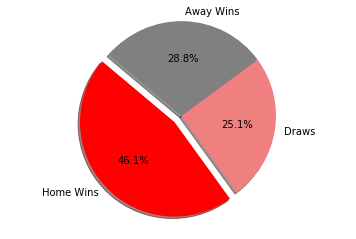

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
 
# Data to plot
labels = 'Home Wins', 'Draws', 'Away Wins'
sizes = [n_home_wins, n_draws, n_away_wins]
colors = ['red', 'lightcoral', 'grey']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.savefig('games_pie_chart.png')
plt.show()

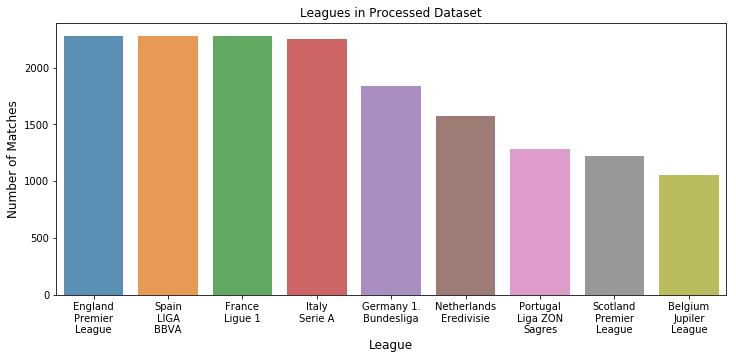

In [46]:
remapped = filtered_og_matches.copy()

ids_to_leagues = {1: "Belgium\nJupiler\nLeague", 1729: "England\nPremier\nLeague", 4769: "France\nLigue 1",
                  7809: "Germany 1.\nBundesliga", 10257: "Italy\nSerie A", 13274: "Netherlands\nEredivisie", 
                  15722: "Poland\nEkstraklasa", 17642: "Portugal\nLiga ZON\nSagres", 19694: "Scotland\nPremier\nLeague",
                  21518: "Spain\nLIGA\nBBVA", 24558: "Switzerland\nSuper\nLeague"
                 }
remapped['league_id'] = remapped['league_id'].map(ids_to_leagues)

counts = remapped['league_id'].value_counts() #.hist() # pd.DataFrame.hist(remapped, column='league_id')

plt.figure(figsize=(12,5))
sns.barplot(counts.index, counts.values, alpha=0.8)
plt.title('Leagues in Processed Dataset')
plt.ylabel('Number of Matches', fontsize=12)
plt.xlabel('League', fontsize=12)
plt.show()

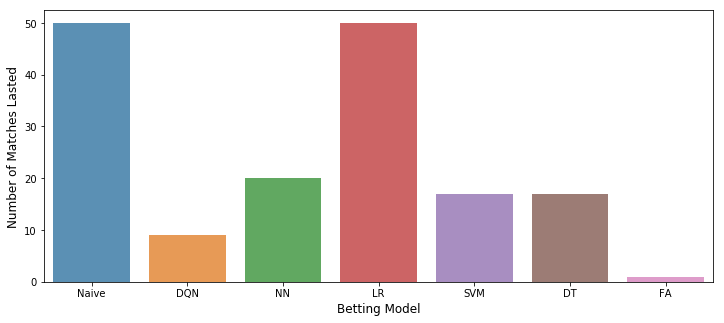

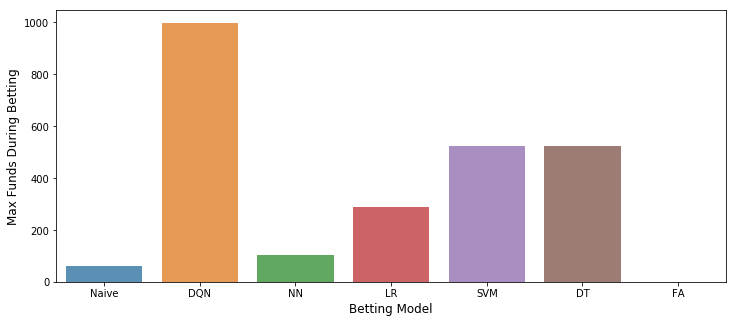

In [39]:
data = {'Naive': [50, 62.5, 56.25, 59.45625, 53.510625, 48.1595625, 43.34360625, 39.009245625, 39.984476765625, 43.58307967453125, 39.224771707078126, 46.0891067558168, 41.48019608023512, 37.33217647221161, 33.59895882499045, 30.2390629424914, 32.50699266317825, 35.757691929496076, 32.18192273654647, 28.96373046289182, 26.06735741660264, 27.631398861598797, 28.18402683883077, 25.365624154947696, 22.829061739452925, 20.546155565507632, 18.491540008956868, 22.467221110882594, 20.220498999794334, 27.90428861971618, 25.113859757744564, 26.495122044420516, 27.819878146641543, 28.932673272507206, 29.42452871813983, 26.482075846325845, 23.83386826169326, 21.450481435523937, 26.770200831533874, 31.722687985367642, 28.55041918683088, 25.69537726814779, 27.160013772432215, 24.444012395188995, 21.999611155670095, 25.40955088479896, 22.868595796319063, 20.58173621668716, 20.84929878750409, 21.245435464466667, 27.364120878233066], 'DQN': [21, 131.0, 64.0, 94.0, 130.0, 178.0, 998.0, 3.0, 0.0], 'NN': [45, 105.0, 78.0, 71.0, 93.0, 84.0, 99.0, 90.0, 81.0, 73.0, 20.0, 18.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 0.0], 'LR': [68.0, 62.0, 95.0, 86.0, 78.0, 71.0, 64.0, 58.0, 82.0, 74.0, 67.0, 61.0, 78.0, 108.0, 98.0, 89.0, 124.0, 152.0, 191.0, 172.0, 155.0, 193.0, 174.0, 259.0, 234.0, 211.0, 287.0, 259.0, 234.0, 211.0, 190.0, 171.0, 154.0, 139.0, 126.0, 162.0, 146.0, 132.0, 119.0, 108.0, 98.0, 89.0, 79.0, 72.0, 88.0, 80.0, 248.0, 224.0, 290.0, 261.0], 'SVM': [39, 429.0, 413.0, 414.0, 418.0, 482.0, 522.0, 470.0, 469.0, 350.0, 297.0, 349.0, 298.0, 287.0, 186.0, 153.0, 0.0], 'DT': [39, 429.0, 413.0, 414.0, 418.0, 482.0, 522.0, 470.0, 469.0, 350.0, 297.0, 349.0, 298.0, 287.0, 186.0, 153.0, 0.0], 'FA': [0]}

n_iterations = list(len(v) for (k, v) in data.items())

model_names = list(data.keys())

# model_names = [m for n, m in sorted(zip(n_iterations,model_names), key=lambda pair: pair[0])]
# n_iterations = sorted(n_iterations)

plt.figure(figsize=(12,5))
sns.barplot(model_names, n_iterations, alpha=0.8)
plt.ylabel('Number of Matches Lasted', fontsize=12)
plt.xlabel('Betting Model', fontsize=12)
plt.savefig('/Users/canrobins13/Desktop/matches_lasted.png')
plt.show()


max_vals = [max(v) for (k, v) in data.items()]
model_names = list(data.keys())

# model_names = [m for n, m in sorted(zip(max_vals,model_names), key=lambda pair: pair[0])]
# max_vals = sorted(max_vals)

plt.figure(figsize=(12,5))
sns.barplot(model_names, max_vals, alpha=0.8)
plt.ylabel('Max Funds During Betting', fontsize=12)
plt.xlabel('Betting Model', fontsize=12)
plt.savefig('/Users/canrobins13/Desktop/max_funds.png')
plt.show()